# Play with Mbs and Bandpasses

In [1]:
# Using this file, we can use "import litebird_sim" even if it is not installed system-wide

In [2]:
import litebird_sim as lbs
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
from astropy.time import Time

To use the IMO bundled in `litebird_sim`, one needs to do the following:

In [3]:
start_time = Time("2025-01-01T00:00:00")
imo = lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION)
sim = lbs.Simulation(
    base_path="inputs",
    imo=imo,
    start_time=start_time,
    duration_s=3600,
    random_seed=12345,
)

Otherwise, if you want to install the IMO, follow the instructions [in the IMO documentation](https://litebird-sim.readthedocs.io/en/master/imo.html#configuring-the-imo). You can install the IMO with the command `python -m litebird_sim.install_imo` with the [schema.json](https://github.com/litebird/litebird_sim/tree/master/default_imo) in `litebird_sim` or with any other local copy. In this case, use the following:

In [4]:
start_time = 0.0
imo = lbs.Imo()
sim = lbs.Simulation(
    base_path="inputs",
    start_time=start_time,
    duration_s=3600,
    random_seed=12345,
)

## One channel

In [5]:
# Initialize the channel
channel = lbs.FreqChannelInfo.from_imo(
    url="/releases/vPTEP/satellite/MFT/M1-140/channel_info", imo=imo
)

In [6]:
# Parameters of Mbs
params = lbs.MbsParameters(
    make_cmb=False,
    make_fg=True,
    fg_models=["pysm_synch_0", "pysm_freefree_1", "pysm_dust_0"],
    nside=64,
    gaussian_smooth=True,
)

In [7]:
# Create the class and run the map generation
mbs = lbs.Mbs(
    simulation=sim,
    parameters=params,
    channel_list=channel,
)
maps = mbs.run_all()[0]

[2024-06-25 23:14:30,550 INFO MPI#0000] generating and saving fg simulations
[2024-06-25 23:14:30,551 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2024-06-25 23:14:30,560 INFO MPI#0000] NSIDE = 512
[2024-06-25 23:14:30,561 INFO MPI#0000] ORDERING = RING in fits file
[2024-06-25 23:14:30,561 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-06-25 23:14:30,628 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2024-06-25 23:14:30,630 INFO MPI#0000] NSIDE = 512
[2024-06-25 23:14:30,630 INFO MPI#0000] ORDERING = RING in fits file
[2024-06-25 23:14:30,631 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-06-25 23:14:30,677 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2024-06-25 23:14:30,679 INFO MPI#0000] NSIDE = 512
[2024-06-25 23:14:30,679 INFO MPI#0000] ORDERING = RING in fits file
[2024-06-25 23:14:30,679 INFO MPI#0000] INDXSCHM = IMPLICIT
OMP: Info #276: omp_set_nested routine deprecated, please use 

In [8]:
maps.keys()

dict_keys(['M1-140', 'Coordinates', 'Mbs_parameters'])

In [9]:
# numpy array with the healpix map
maps["M1-140"].shape

(3, 49152)

In [10]:
# Coordinates of the simulated maps
maps["Coordinates"]

<CoordinateSystem.Galactic: 2>

In [11]:
# Parameters of the Mbs simulations
maps["Mbs_parameters"]

MbsParameters(nside=64, save=False, gaussian_smooth=True, bandpass_int=False, coadd=True, parallel_mc=False, make_noise=False, nmc_noise=1, seed_noise=None, n_split=False, make_cmb=False, cmb_ps_file='', cmb_r=0.0, nmc_cmb=1, seed_cmb=None, make_fg=True, fg_models={'pysm_synch_0': 'pysm_synch_0', 'pysm_freefree_1': 'pysm_freefree_1', 'pysm_dust_0': 'pysm_dust_0'}, make_dipole=False, sun_velocity=None, output_string='date_240625', units='K_CMB', maps_in_ecliptic=False, store_alms=False, lmax_alms=256)

## Many channels

In [12]:
# Obtain the info about the instrument from the imo
instrument = lbs.InstrumentInfo.from_imo(
    url="/releases/vPTEP/satellite/MFT/instrument_info", imo=imo
)

In [13]:
# Create a list with all the channels
channels = list()
for ch in instrument.channel_names:
    print(ch)
    channels.append(
        lbs.FreqChannelInfo.from_imo(
            url="/releases/vPTEP/satellite/MFT/" + ch + "/channel_info", imo=imo
        )
    )

M1-100
M2-119
M1-140
M2-166
M1-195


In [14]:
# Same as before but using the uuids
channels = list()
for uuid in instrument.channel_objs:
    channel = lbs.FreqChannelInfo.from_imo(url=uuid, imo=imo)
    print(channel.channel)
    channels.append(channel)

M1-100
M2-119
M1-140
M2-166
M1-195


In [15]:
mbs = lbs.Mbs(
    simulation=sim,
    parameters=params,
    channel_list=channels,
)
maps = mbs.run_all()[0]

[2024-06-25 23:14:32,992 INFO MPI#0000] generating and saving fg simulations
[2024-06-25 23:14:32,993 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2024-06-25 23:14:32,994 INFO MPI#0000] NSIDE = 512
[2024-06-25 23:14:32,994 INFO MPI#0000] ORDERING = RING in fits file
[2024-06-25 23:14:32,994 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-06-25 23:14:33,039 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2024-06-25 23:14:33,040 INFO MPI#0000] NSIDE = 512
[2024-06-25 23:14:33,040 INFO MPI#0000] ORDERING = RING in fits file
[2024-06-25 23:14:33,040 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-06-25 23:14:33,085 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2024-06-25 23:14:33,087 INFO MPI#0000] NSIDE = 512
[2024-06-25 23:14:33,087 INFO MPI#0000] ORDERING = RING in fits file
[2024-06-25 23:14:33,087 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-06-25 23:14:33,166 INFO MPI#0000] Sigma is 16.052182 arc

In [16]:
for k in maps.keys():
    print(k)

M1-100
M2-119
M1-140
M2-166
M1-195
Coordinates
Mbs_parameters


## Some detectors

In [17]:
# Now we create a list of detectors
channel = lbs.FreqChannelInfo.from_imo(
    url="/releases/vPTEP/satellite/MFT/M1-140/channel_info", imo=imo
)
wafer = "M02"
orient = "Q"
dets = []
for uuid in channel.detector_objs:
    det = lbs.DetectorInfo.from_imo(url=uuid, imo=imo)
    if (det.wafer == wafer) and (det.orient == orient):
        dets.append(det)

In [18]:
# We run as before but with detector_list instead of channel_list
mbs = lbs.Mbs(
    simulation=sim,
    parameters=params,
    detector_list=dets,
)
maps = mbs.run_all()[0]

[2024-06-25 23:14:33,980 INFO MPI#0000] generating and saving fg simulations
[2024-06-25 23:14:33,981 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2024-06-25 23:14:33,982 INFO MPI#0000] NSIDE = 512
[2024-06-25 23:14:33,983 INFO MPI#0000] ORDERING = RING in fits file
[2024-06-25 23:14:33,983 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-06-25 23:14:34,029 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2024-06-25 23:14:34,030 INFO MPI#0000] NSIDE = 512
[2024-06-25 23:14:34,030 INFO MPI#0000] ORDERING = RING in fits file
[2024-06-25 23:14:34,031 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-06-25 23:14:34,076 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2024-06-25 23:14:34,078 INFO MPI#0000] NSIDE = 512
[2024-06-25 23:14:34,078 INFO MPI#0000] ORDERING = RING in fits file
[2024-06-25 23:14:34,078 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-06-25 23:14:34,157 INFO MPI#0000] Sigma is 13.079556 arc

[2024-06-25 23:14:35,177 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-25 23:14:35,177 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-06-25 23:14:35,220 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-06-25 23:14:35,220 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-06-25 23:14:35,221 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-25 23:14:35,221 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-06-25 23:14:35,260 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-06-25 23:14:35,261 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-06-25 23:14:35,261 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-25 23:14:35,262 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-06-25 23:14:35,301 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-06-25 23:14:35,301 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-06-25 23:14:35,301 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-25 23:14:35,302 

[2024-06-25 23:14:36,344 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-06-25 23:14:36,344 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-06-25 23:14:36,345 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-25 23:14:36,345 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-06-25 23:14:36,384 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-06-25 23:14:36,384 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-06-25 23:14:36,385 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-25 23:14:36,385 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-06-25 23:14:36,426 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-06-25 23:14:36,426 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-06-25 23:14:36,427 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-25 23:14:36,427 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-06-25 23:14:36,467 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-06-25 23:14:36,468

[2024-06-25 23:14:37,452 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-06-25 23:14:37,492 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-06-25 23:14:37,492 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-06-25 23:14:37,493 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-25 23:14:37,493 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-06-25 23:14:37,531 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-06-25 23:14:37,531 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-06-25 23:14:37,532 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-25 23:14:37,532 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-06-25 23:14:37,570 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-06-25 23:14:37,570 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-06-25 23:14:37,571 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-25 23:14:37,571 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-06-25 23:14:37,609 INFO MPI#0000]

[2024-06-25 23:14:38,561 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-06-25 23:14:38,562 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-25 23:14:38,562 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-06-25 23:14:38,600 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-06-25 23:14:38,600 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-06-25 23:14:38,600 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-25 23:14:38,601 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-06-25 23:14:38,639 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-06-25 23:14:38,639 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-06-25 23:14:38,640 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-25 23:14:38,640 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-06-25 23:14:38,678 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-06-25 23:14:38,678 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-06-25 23:14:38,679 INFO MPI#0000

[2024-06-25 23:14:39,635 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-06-25 23:14:39,674 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-06-25 23:14:39,675 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-06-25 23:14:39,675 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-25 23:14:39,676 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-06-25 23:14:39,715 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-06-25 23:14:39,715 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-06-25 23:14:39,716 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-25 23:14:39,716 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-06-25 23:14:39,755 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-06-25 23:14:39,755 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-06-25 23:14:39,756 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-25 23:14:39,756 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-06-25 23:14:39,795 INFO MPI#0000]

[2024-06-25 23:14:40,808 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-25 23:14:40,808 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-06-25 23:14:40,848 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-06-25 23:14:40,848 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-06-25 23:14:40,849 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-25 23:14:40,849 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-06-25 23:14:40,889 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-06-25 23:14:40,889 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-06-25 23:14:40,890 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-25 23:14:40,890 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-06-25 23:14:40,929 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-06-25 23:14:40,930 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-06-25 23:14:40,930 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-25 23:14:40,931 

[2024-06-25 23:14:41,946 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-06-25 23:14:41,947 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-06-25 23:14:41,947 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-25 23:14:41,947 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-06-25 23:14:41,986 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-06-25 23:14:41,987 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-06-25 23:14:41,987 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-25 23:14:41,987 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-06-25 23:14:42,027 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-06-25 23:14:42,027 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2024-06-25 23:14:42,027 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-06-25 23:14:42,028 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-06-25 23:14:42,067 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2024-06-25 23:14:42,067

In [19]:
for k in maps.keys():
    print(k)

001_002_030_00A_140_T
001_002_030_00A_140_B
001_002_031_15B_140_T
001_002_031_00B_140_B
001_002_022_15A_140_T
001_002_022_00A_140_B
001_002_039_15A_140_T
001_002_039_00A_140_B
001_002_023_15B_140_T
001_002_023_00B_140_B
001_002_015_15A_140_T
001_002_015_00A_140_B
001_002_047_15A_140_T
001_002_047_00A_140_B
001_002_040_15B_140_T
001_002_040_00B_140_B
001_002_016_15B_140_T
001_002_016_00B_140_B
001_002_009_15A_140_T
001_002_009_00A_140_B
001_002_006_30B_140_T
001_002_006_00B_140_B
001_002_012_30B_140_T
001_002_012_00B_140_B
001_002_019_30B_140_T
001_002_019_00B_140_B
001_002_027_30B_140_T
001_002_027_00B_140_B
001_002_036_30B_140_T
001_002_036_00B_140_B
001_002_044_15B_140_T
001_002_044_00B_140_B
001_002_051_15B_140_T
001_002_051_00B_140_B
001_002_054_15A_140_T
001_002_054_00A_140_B
001_002_048_15B_140_T
001_002_048_00B_140_B
001_002_034_15A_140_T
001_002_034_00A_140_B
001_002_010_15B_140_T
001_002_010_00B_140_B
001_002_004_15A_140_T
001_002_004_00A_140_B
001_002_001_30B_140_T
001_002_00

## Now integrating over a top-hat bandpass

In [20]:
channel = lbs.FreqChannelInfo.from_imo(
    url="/releases/vPTEP/satellite/MFT/M1-140/channel_info", imo=imo
)

In [21]:
# We generate maps with an without band integration
params = lbs.MbsParameters(
    make_cmb=False,
    make_fg=True,
    fg_models=["pysm_synch_0", "pysm_freefree_1", "pysm_dust_0"],
    nside=64,
    gaussian_smooth=True,
)
mbs = lbs.Mbs(
    simulation=sim,
    parameters=params,
    channel_list=channel,
)
mapsnoint = mbs.run_all()[0]

params = lbs.MbsParameters(
    make_cmb=False,
    make_fg=True,
    fg_models=["pysm_synch_0", "pysm_freefree_1", "pysm_dust_0"],
    nside=64,
    gaussian_smooth=True,
    bandpass_int=True,
)
mbs = lbs.Mbs(
    simulation=sim,
    parameters=params,
    channel_list=channel,
)
mapsint = mbs.run_all()[0]

[2024-06-25 23:14:42,923 INFO MPI#0000] generating and saving fg simulations
[2024-06-25 23:14:42,924 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2024-06-25 23:14:42,925 INFO MPI#0000] NSIDE = 512
[2024-06-25 23:14:42,926 INFO MPI#0000] ORDERING = RING in fits file
[2024-06-25 23:14:42,926 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-06-25 23:14:42,990 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2024-06-25 23:14:42,991 INFO MPI#0000] NSIDE = 512
[2024-06-25 23:14:42,991 INFO MPI#0000] ORDERING = RING in fits file
[2024-06-25 23:14:42,992 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-06-25 23:14:43,038 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2024-06-25 23:14:43,040 INFO MPI#0000] NSIDE = 512
[2024-06-25 23:14:43,040 INFO MPI#0000] ORDERING = RING in fits file
[2024-06-25 23:14:43,040 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-06-25 23:14:43,120 INFO MPI#0000] Sigma is 13.079556 arc

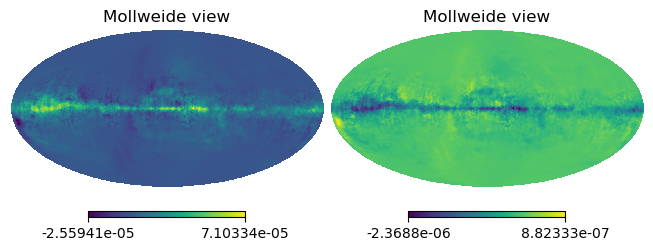

In [22]:
hp.mollview(mapsint["M1-140"][1], sub=121)
hp.mollview((mapsnoint["M1-140"] - mapsint["M1-140"])[1], sub=122)

## Now with a customized bandpass

Text(0, 0.5, 'Transmission')

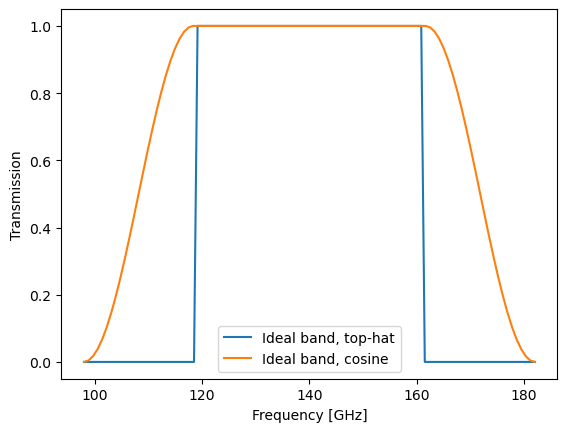

In [23]:
# We change the shape of the bands, in channel1 top-hat in channel2 top-hat with cosine tails

channel1 = lbs.FreqChannelInfo.from_imo(
    url="/releases/vPTEP/satellite/MFT/M1-140/channel_info", imo=imo
)

band = lbs.BandPassInfo(
    bandcenter_ghz=channel1.bandcenter_ghz,
    bandwidth_ghz=channel1.bandwidth_ghz,
    bandtype="top-hat-cosine",
    nsamples_inband=100,
)
channel2 = lbs.FreqChannelInfo.from_imo(
    url="/releases/vPTEP/satellite/MFT/M1-140/channel_info", imo=imo
)
channel2.band = band

plt.plot(channel1.band.freqs_ghz, channel1.band.weights, label="Ideal band, top-hat")
plt.plot(channel2.band.freqs_ghz, channel2.band.weights, label="Ideal band, cosine")
plt.legend()
plt.xlabel("Frequency [GHz]")
plt.ylabel("Transmission")

In [24]:
# Here we do the comparison
params = lbs.MbsParameters(
    make_cmb=False,
    make_fg=True,
    fg_models=["pysm_synch_0", "pysm_freefree_1", "pysm_dust_0"],
    nside=64,
    gaussian_smooth=True,
    bandpass_int=True,
)
mbs = lbs.Mbs(
    simulation=sim,
    parameters=params,
    channel_list=channel1,
)
mapsth = mbs.run_all()[0]

mbs = lbs.Mbs(
    simulation=sim,
    parameters=params,
    channel_list=channel2,
)
mapsthc = mbs.run_all()[0]

[2024-06-25 23:14:44,271 INFO MPI#0000] generating and saving fg simulations
[2024-06-25 23:14:44,272 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2024-06-25 23:14:44,273 INFO MPI#0000] NSIDE = 512
[2024-06-25 23:14:44,274 INFO MPI#0000] ORDERING = RING in fits file
[2024-06-25 23:14:44,274 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-06-25 23:14:44,327 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2024-06-25 23:14:44,328 INFO MPI#0000] NSIDE = 512
[2024-06-25 23:14:44,328 INFO MPI#0000] ORDERING = RING in fits file
[2024-06-25 23:14:44,329 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-06-25 23:14:44,375 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2024-06-25 23:14:44,376 INFO MPI#0000] NSIDE = 512
[2024-06-25 23:14:44,377 INFO MPI#0000] ORDERING = RING in fits file
[2024-06-25 23:14:44,377 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-06-25 23:14:44,459 INFO MPI#0000] Removing 64/128 points

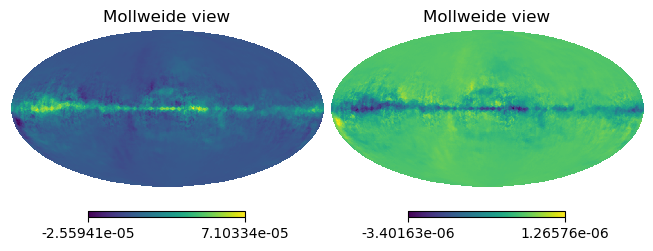

In [25]:
hp.mollview(mapsth["M1-140"][1], sub=121)
hp.mollview((mapsth["M1-140"] - mapsthc["M1-140"])[1], sub=122)

## Scan the sky

In [26]:
# Now we do a simple simulation of 1 hour with 4 detectors
telescope = "MFT"
channel = "M1-140"
detlist = [
    "001_004_060_30A_140_T",
    "001_003_000_00A_140_B",
    "001_003_001_00B_140_T",
    "001_003_002_45A_140_B",
]

In [27]:
start_time = 0.0
imo = lbs.Imo()
sim = lbs.Simulation(
    base_path="./inputs",
    start_time=start_time,
    duration_s=3600,
    random_seed=12345,
)

Can't resample if no sampler is built and/or provided, initializing the sampler and interpolating the band


/opt/homebrew/Caskroom/miniconda/base/envs/litebird_sim/lib/python3.10/site-packages/litebird_sim/bandpasses.py:271: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  sp.integrate.quad(b, a=self.freqs_ghz.min(), b=inu)[0]
/opt/homebrew/Caskroom/miniconda/base/envs/litebird_sim/lib/python3.10/site-packages/litebird_sim/bandpasses.py:271: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  sp.integrate.quad(b, a=self.freqs_ghz.min(), b=inu)[0]


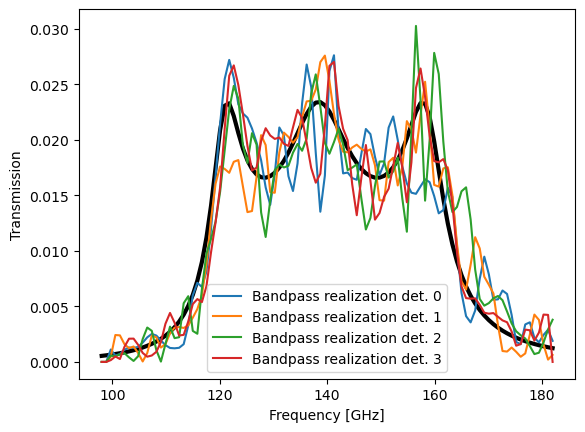

In [28]:
# Load the definition of the instrument (MFT)
sim.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/vPTEP/satellite/{telescope}/instrument_info",
    )
)

channelinfo = lbs.FreqChannelInfo.from_imo(
    imo, f"/releases/vPTEP/satellite/{telescope}/{channel}/channel_info"
)

band = lbs.BandPassInfo(
    bandcenter_ghz=channelinfo.bandcenter_ghz,
    bandwidth_ghz=channelinfo.bandwidth_ghz,
    bandtype="cheby",
    nsamples_inband=100,
    normalize=True,
)

plt.plot(band.freqs_ghz, band.weights, lw=3, color="k")

dets = []
for i, namedet in enumerate(detlist):
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/vPTEP/satellite/{telescope}/{channel}/{namedet}/detector_info",
        imo=imo,
    )
    det.quat = lbs.RotQuaternion(quats=np.array([0.0, 0.0, 0.0, 1.0]))
    det.band = band
    det.fwhm_arcmin *= np.random.normal(1.0, 0.01)
    det.band.weights = band.bandpass_resampling()
    dets.append(det)
    plt.plot(band.freqs_ghz, det.band.weights, label=f"Bandpass realization det. {i}")
    plt.xlabel("Frequency [GHz]")
    plt.ylabel("Transmission")
    plt.legend()

In [29]:
sim.set_scanning_strategy(imo_url="/releases/vPTEP/satellite/scanning_parameters/")

sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,  # blocks different from one if parallelizing
)

In [30]:
params = lbs.MbsParameters(
    make_cmb=False,
    make_fg=True,
    fg_models=["pysm_synch_0", "pysm_freefree_1", "pysm_dust_0"],
    nside=64,
    gaussian_smooth=True,
    bandpass_int=True,
)
mbs = lbs.Mbs(
    simulation=sim,
    parameters=params,
    detector_list=dets,
)
maps = mbs.run_all()[0]

[2024-06-25 23:14:47,180 INFO MPI#0000] generating and saving fg simulations
[2024-06-25 23:14:47,181 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2024-06-25 23:14:47,182 INFO MPI#0000] NSIDE = 512
[2024-06-25 23:14:47,183 INFO MPI#0000] ORDERING = RING in fits file
[2024-06-25 23:14:47,183 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-06-25 23:14:47,238 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2024-06-25 23:14:47,239 INFO MPI#0000] NSIDE = 512
[2024-06-25 23:14:47,240 INFO MPI#0000] ORDERING = RING in fits file
[2024-06-25 23:14:47,240 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-06-25 23:14:47,286 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2024-06-25 23:14:47,287 INFO MPI#0000] NSIDE = 512
[2024-06-25 23:14:47,288 INFO MPI#0000] ORDERING = RING in fits file
[2024-06-25 23:14:47,288 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-06-25 23:14:47,362 INFO MPI#0000] Removing 97/100 points

In [31]:
sim.set_hwp(
    lbs.IdealHWP(
        sim.instrument.hwp_rpm * 2 * np.pi / 60,
    ),
)
sim.prepare_pointings()

In [32]:
sim.fill_tods(maps)

In [33]:
maps.keys()

dict_keys(['001_004_060_30A_140_T', '001_003_000_00A_140_B', '001_003_001_00B_140_T', '001_003_002_45A_140_B', 'Coordinates', 'Mbs_parameters'])

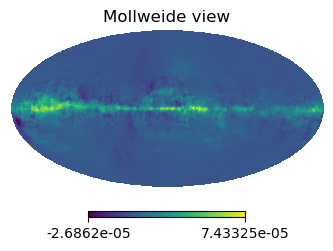

In [34]:
hp.mollview(maps["001_004_060_30A_140_T"][1], sub=121)
# This map is slightly different from the previous ones due to the different bandpass

Text(0, 0.5, 'Signal [K]')

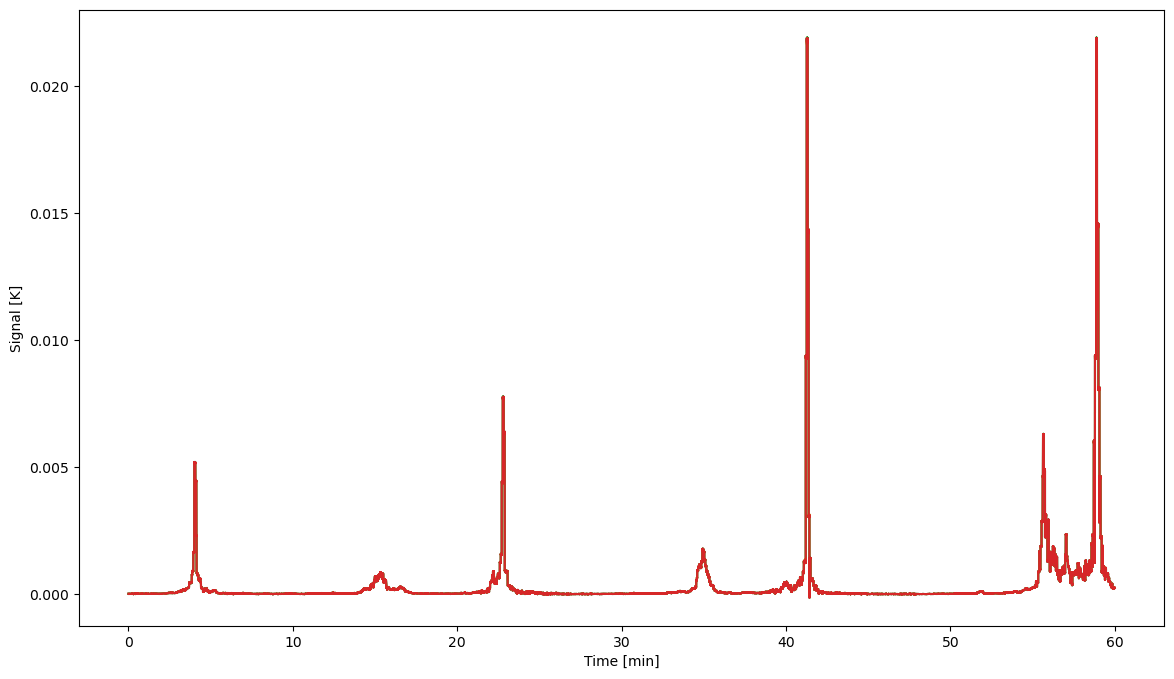

In [35]:
times_min = (sim.observations[0].get_times() - sim.observations[0].start_time) / 60.0
plt.figure(figsize=(14, 8))
plt.plot(times_min, sim.observations[0].tod[0])
plt.plot(times_min, sim.observations[0].tod[1])
plt.plot(times_min, sim.observations[0].tod[2])
plt.plot(times_min, sim.observations[0].tod[3])

plt.xlabel("Time [min]")
plt.ylabel("Signal [K]")

Text(0, 0.5, '$\\Delta$ Signal [K]')

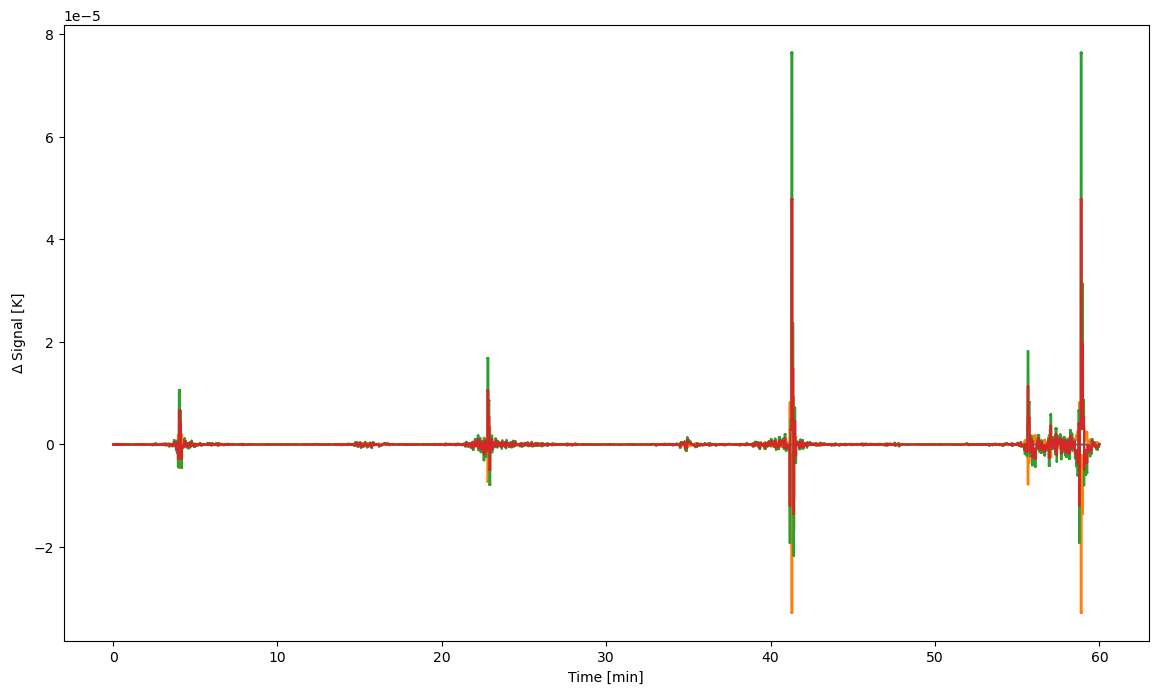

In [36]:
plt.figure(figsize=(14, 8))
plt.plot(times_min, sim.observations[0].tod[0] - sim.observations[0].tod[0])
plt.plot(times_min, sim.observations[0].tod[1] - sim.observations[0].tod[0])
plt.plot(times_min, sim.observations[0].tod[2] - sim.observations[0].tod[0])
plt.plot(times_min, sim.observations[0].tod[3] - sim.observations[0].tod[0])

plt.xlabel("Time [min]")
plt.ylabel(r"$\Delta$ Signal [K]")